In [276]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import math
import warnings
import scipy.stats as stats
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

from IPython.display import display
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
sns.set(style='whitegrid', palette='mako')

warnings.filterwarnings(
    action='ignore',
    module='scipy',
    message='^internal gelsd')

def regstats (regr):
    print('Coefficients:\n{}\n'.format(lm.params))
    print('p-values:\n{}\n'.format(lm.pvalues))
    print('R-Squared:\n{}\n'.format(lm.rsquared))
    print('Confidence Interval:\n{}'.format(lm.conf_int()))
    prstd, iv_l, iv_u = wls_prediction_std(lm)
    plt.figure()
    plt.plot(iv_u[0:100], 'o', color='r')
    plt.plot(iv_l[0:100], 'o', color='r')
    plt.plot(lm.fittedvalues[0:100], 'o', color='b')
    plt.title('blue: predicted, red: 95% CI')
    plt.show()
    
    
#fucntion to clean FBI crime xls   
def cleandata (state):
    state.columns = map(str.lower, state.columns)
    state.columns = state.columns.str.split().str[0].str.strip()
    state.fillna(0, inplace=True)
    state.columns.values[5] = 'rape0'
    cols = state[['population', 'violent', 'robbery','rape0', 'aggravated', 'property', 'burglary', 'larceny-', 'arson3', 'motor']]
    for col in cols:    
        state[col] = state[col].astype(str)
        state[col] = state[col].str.replace(',','')
        state[col] = state[col].apply(pd.to_numeric)
    state.drop(columns='rape', inplace=True)
    
#function to return concerned indicators
def modelstats (lm):
    plt.figure()
    plt.hist(lm.resid)
    plt.title('Residual counts')
    plt.xlabel('Residual')
    plt.ylabel('Count')
    plt.show()
    plt.figure()
    plt.scatter(lm.predict(), lm.resid)
    plt.xlabel("Predicted")
    plt.ylabel("Residual")
    plt.axhline(y=0,color='red')
    plt.title('Predicted vs Residual')
    plt.show()
    regstats(lm)
    print("Residuals mean: {}".format(sum(lm.resid)/len(lm.resid)))
    
    
def addfeatures(state):
    state['popsq'] = state['population']**2
    means = state[['violent','aggravated','burglary']].mean(axis=0)
    stds = state[['violent','aggravated','burglary']].std(axis=0)
    state['V_A_B'] = ((state[['violent','aggravated','burglary']] - means)/ stds).mean(axis=1)
    state['arson3'] = np.where((state['arson3']>0), 1, 0)
    state['motor'] = np.where((state['motor']>0), 1, 0)
    state['robbery'] = np.where((state['robbery']>0), 1, 0)
    state['murder'] = np.where((state['murder']>0), 1, 0)
    state['larceny']=state['larceny-']
    state.drop(columns='larceny-', inplace=True)

In [277]:
data = pd.read_csv('newyorkcrime.csv')
cleandata(data)

In [278]:
#A quick visuaization,
'''
sns.set_style('darkgrid')
g = sns.PairGrid(data.dropna(), diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)
plt.show()
'''

"\nsns.set_style('darkgrid')\ng = sns.PairGrid(data.dropna(), diag_sharey=False)\ng.map_upper(plt.scatter, alpha=.5)\ng.map_lower(sns.regplot, scatter_kws=dict(alpha=0))\ng.map_diag(sns.kdeplot, lw=3)\nplt.show()\n"

In [279]:
data.population.describe()

count       348.000
mean      40037.632
std      450037.368
min         526.000
25%        3003.000
50%        7233.500
75%       18427.500
max     8396126.000
Name: population, dtype: float64

In [280]:
#reduce data to see the variable wise relationships
data = data.loc[data['population'] <= 20000]

In [281]:
'''
#visual reduce data
sns.set_style('darkgrid')
g = sns.PairGrid(data.dropna(), diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)
plt.show()
'''

"\n#visual reduce data\nsns.set_style('darkgrid')\ng = sns.PairGrid(data.dropna(), diag_sharey=False)\ng.map_upper(plt.scatter, alpha=.5)\ng.map_lower(sns.regplot, scatter_kws=dict(alpha=0))\ng.map_diag(sns.kdeplot, lw=3)\nplt.show()\n"

In [282]:
squares = pd.DataFrame()
logs = pd.DataFrame()
sqrts = pd.DataFrame()
def createfeats (df):
    for col in df.loc[:,'population':]:
        squares[col+'_sq'] = df[col]**2
        sqrts[col+'_sqrt'] = df[col]**.5
        mask=(df[col] != 0)
        logable = df[mask]
        logs.loc[mask, col+'_log'] = np.log(logable[col])
    squares.fillna(0, inplace=True)
    sqrts.fillna(0, inplace=True)
    logs.fillna(0, inplace=True)

In [283]:
createfeats(data)

/root/.pyenv/versions/jupyter3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


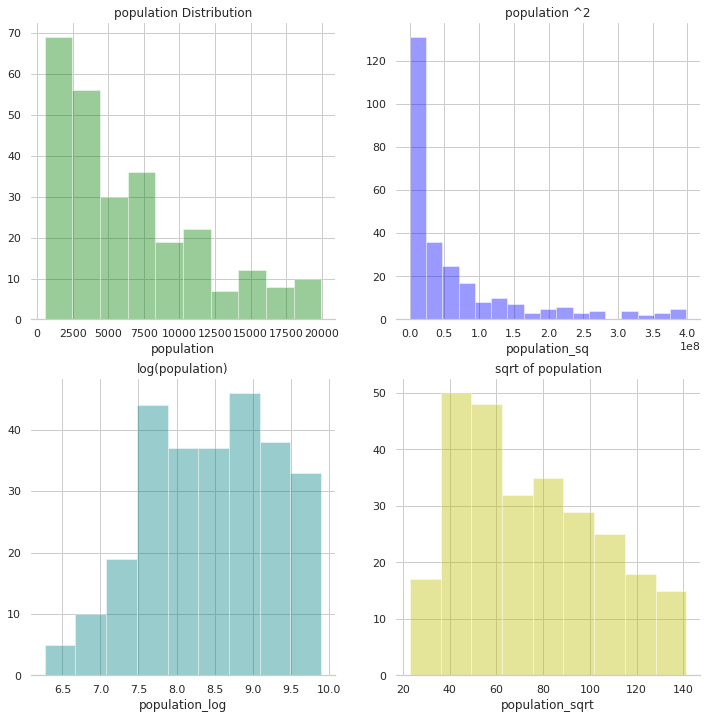

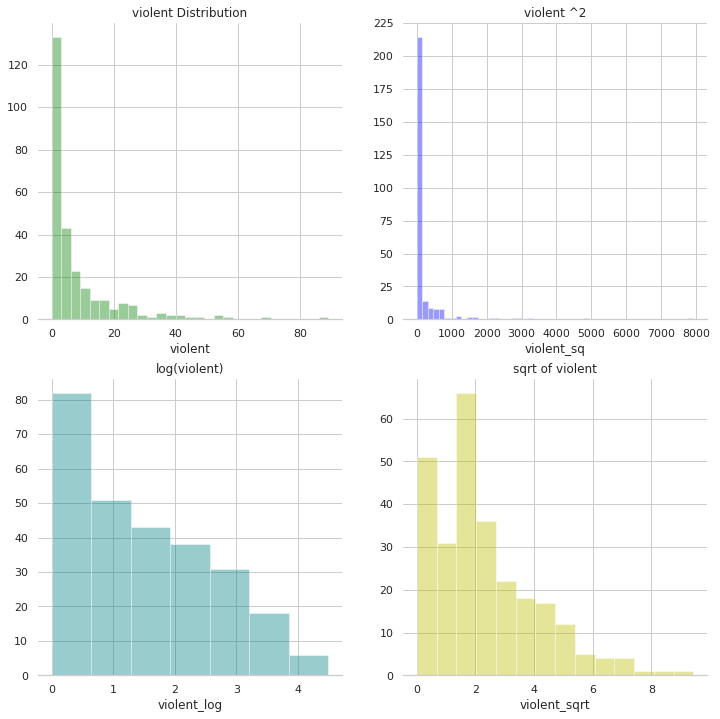

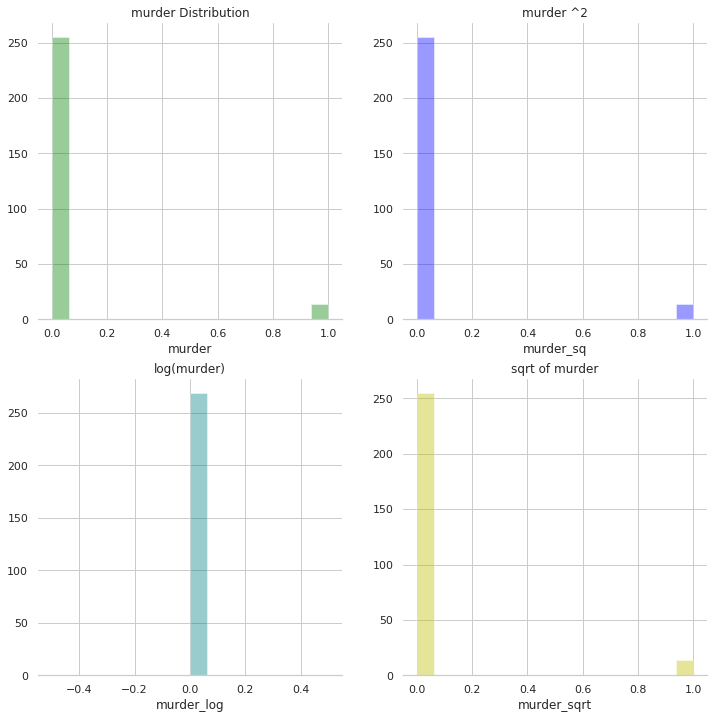

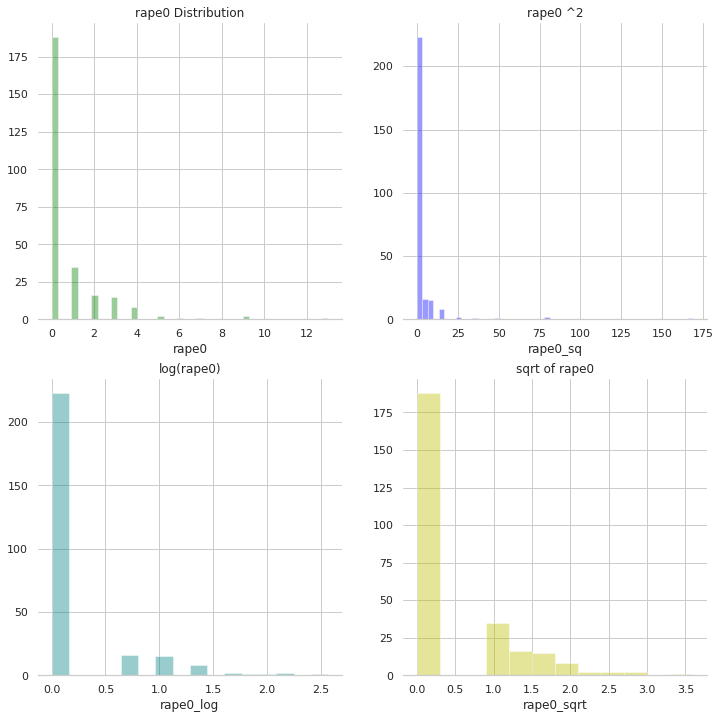

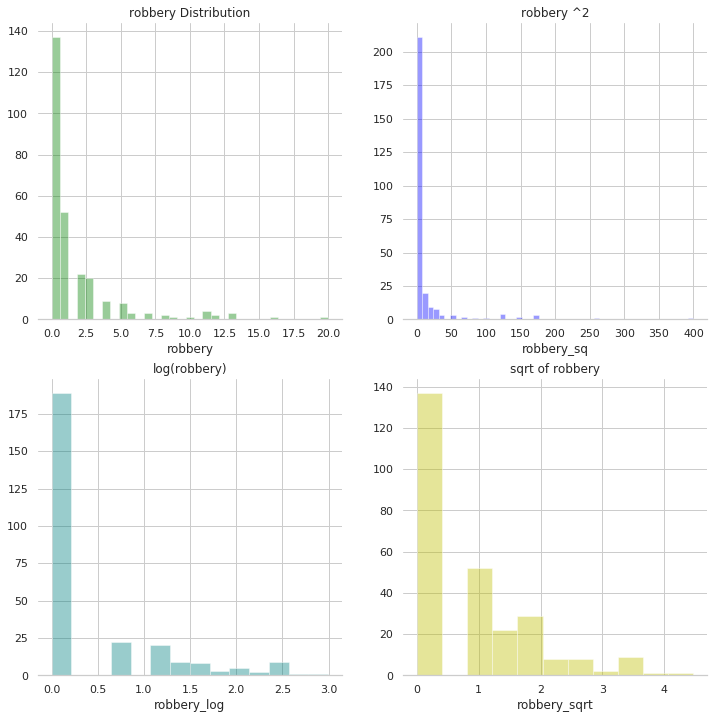

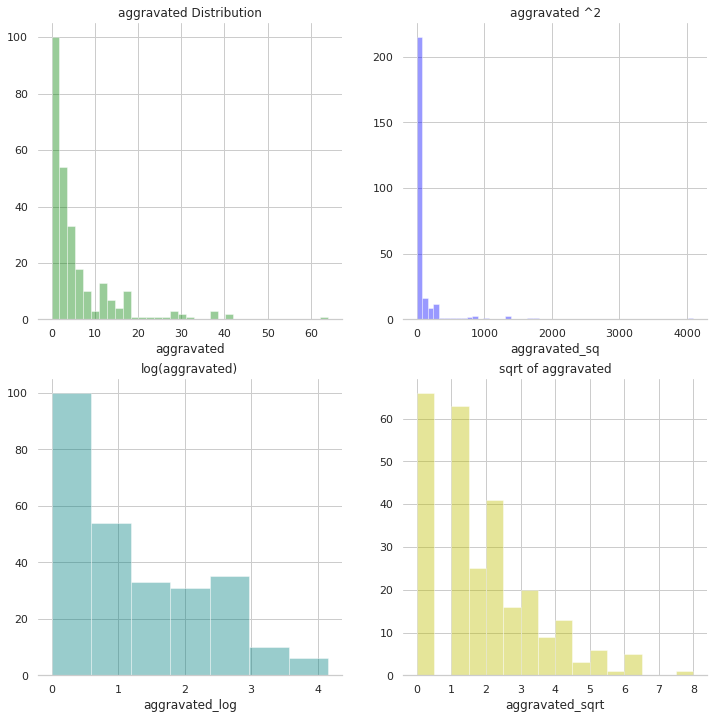

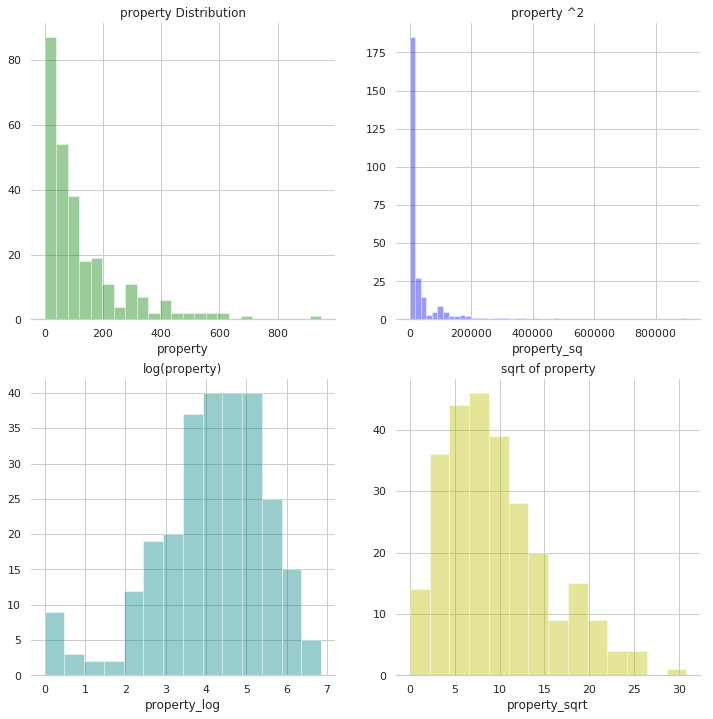

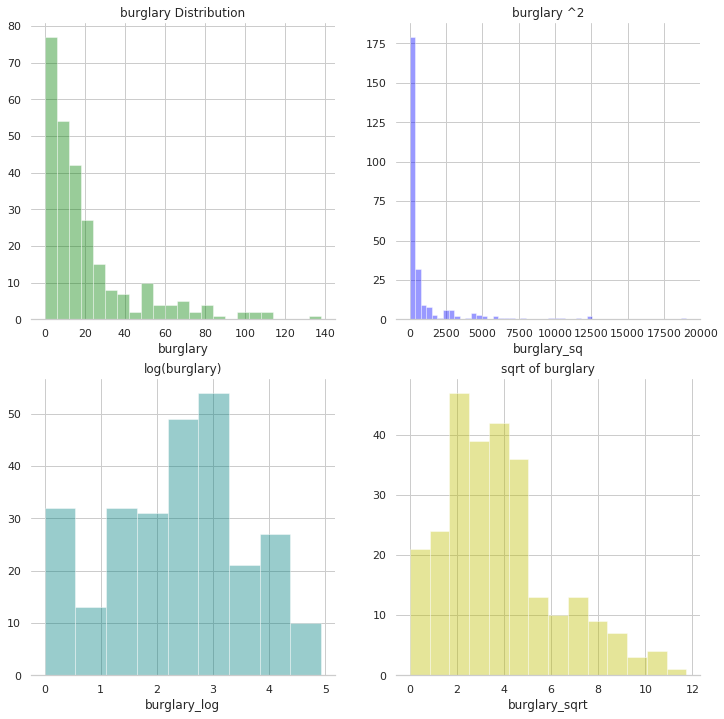

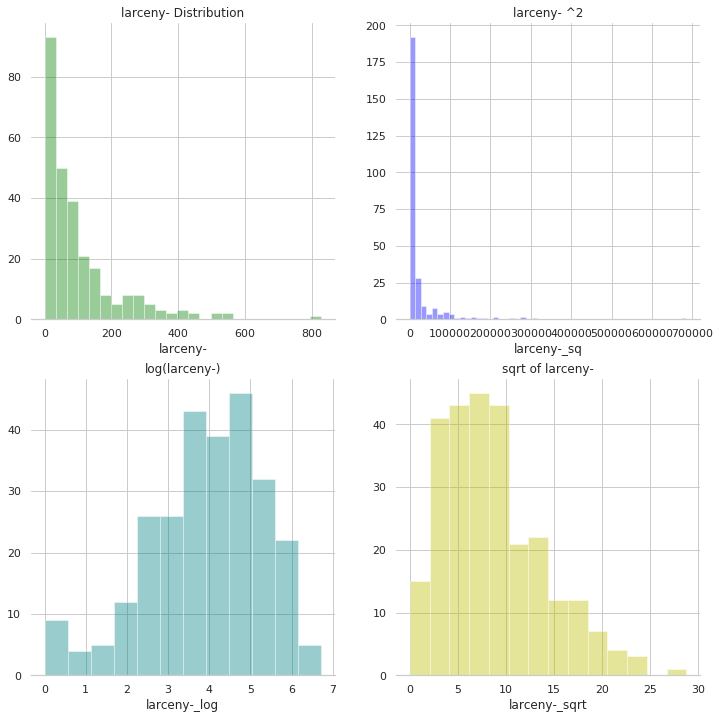

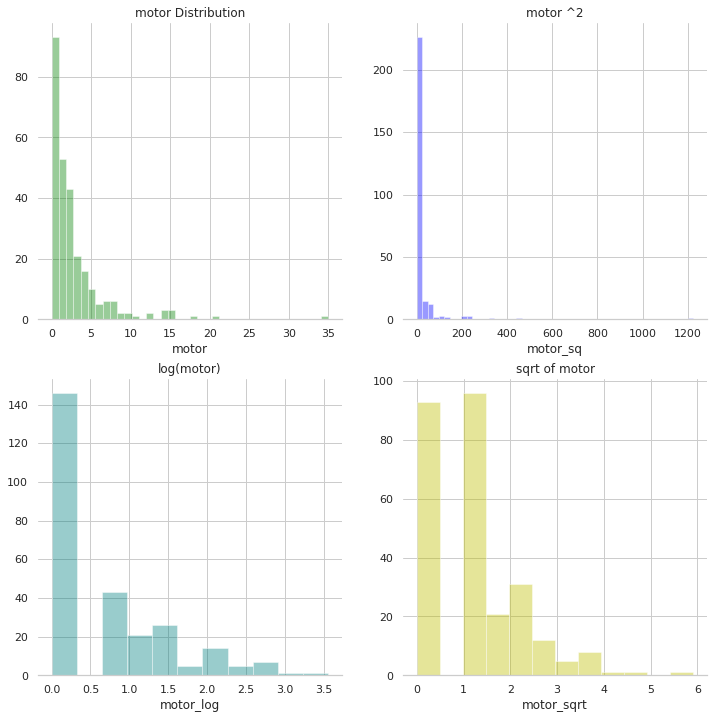

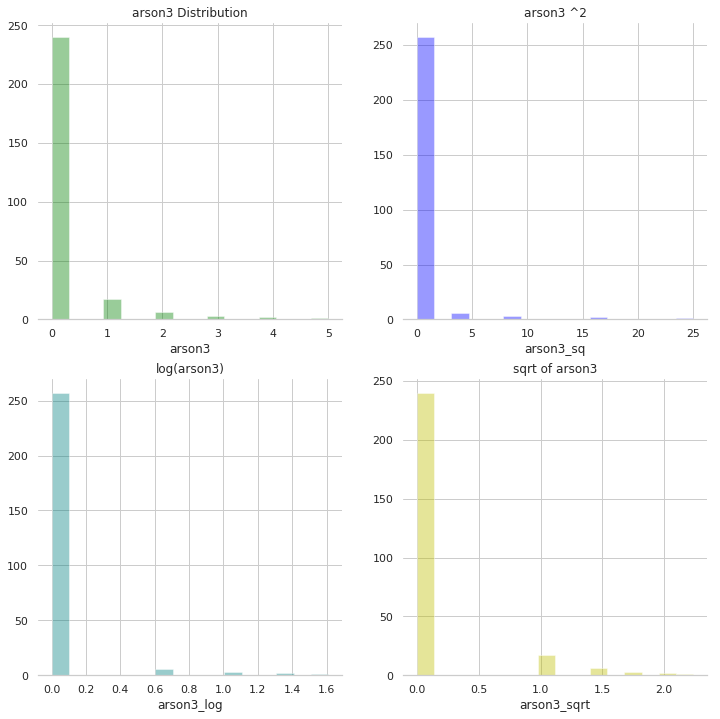

In [284]:
for col in data.loc[:,'population':]:
    sns.set(style="whitegrid", palette="icefire", color_codes=True)
    f, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=False)
    sns.despine(left=True)
    sns.distplot(data[col], color='g',kde=False, ax=axes[0, 0]).set_title("{} Distribution".format(col))
    sns.distplot(squares[col+'_sq'], color='b',kde=False,ax=axes[0, 1]).set_title("{} ^2".format(col))
    sns.distplot(logs[col+'_log'],color='teal',kde=False, ax=axes[1, 0]).set_title('log({})'.format(col))
    sns.distplot(sqrts[col+'_sqrt'],color='y', kde=False, ax=axes[1, 1]).set_title('sqrt of {}'.format(col))
    plt.show()
   

In [ ]:
#the log seems to get the data to the most normaly distributed looking data

In [ ]:
model = pd.DataFrame()
model['property'] = model[]